# Предсказание направления цены - Биктоин - Временной интервал 15 минут

In [42]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN,ConvLSTM2D, RNN, ConvLSTM1D, ConvLSTM3D
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D, Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import keras_tuner
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
import cryptocompare

In [1]:
pip install cryptocompare

  Preparing metadata (setup.py) ... done
  Created wheel for cryptocompare: filename=cryptocompare-0.7.6-py3-none-any.whl size=6302 sha256=7e12662bf2731b5f5101386f2916623eb3814de7b23965ff3137d4f50abdbbda
  Stored in directory: /root/.cache/pip/wheels/97/81/6a/261bc499b9d9bf8b391eea52c90a4746b477539564b0a66c94
Successfully built cryptocompare
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 which is incompatible.
kfp 1.8.20 requires PyYAML<6,>=5.3, but you have pyyaml 6.0 which is incompatible.
gcsfs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2023.4.0 which is incompatible.
cudf 23.4.0 requires protobuf<4.22,>=4.21.6, but you have protobuf 3.19.6 which is incompatible.
beatrix

In [43]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from datetime import date, timedelta, datetime
import seaborn as sns
sns.set_style('white', {'axes.spines.right': True, 'axes.spines.top': False})

import san
san.ApiConfig.api_key = "5g33k3hjcghlfotr_ggr666n4uu4ejwr3"

# Data Collection

In [3]:
OHLCV = []
end = datetime(2023,4,24)
for i in range(10):
    start = end - timedelta(days = 20)
    part = san.get(
          "ohlc",
          slug="bitcoin",
          from_date=start,
          to_date=end,
          interval="15m"
        )
    OHLCV.append(part)
    end = start

OHLCV = list(reversed(OHLCV))
OHLCV = pd.concat(OHLCV)
OHLCV

KeyboardInterrupt: 

In [6]:
OHLCV.rename(columns={'closePriceUsd':'close', 'highPriceUsd':'high', 'lowPriceUsd':'low', 'openPriceUsd':'open'}, inplace=True)

In [7]:
OHLCV.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19200 entries, 2022-10-06 00:00:00+00:00 to 2023-04-23 23:45:00+00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   19200 non-null  float64
 1   high    19200 non-null  float64
 2   low     19200 non-null  float64
 3   open    19200 non-null  float64
dtypes: float64(4)
memory usage: 750.0 KB


In [8]:
OHLCV.describe()

,close,high,low,open
count,19200.000000,19200.000000,19200.000000,19200.000000
mean,21421.981310,21437.026838,21406.882920,21421.982630
std,4230.933084,4235.934848,4225.831230,4230.936720
min,15652.828667,15687.276846,15599.047175,15648.961196
25%,17039.612943,17051.572178,17032.699266,17038.921412
50%,20772.195330,20786.599601,20758.640405,20771.963380
75%,23815.884533,23831.007008,23800.710268,23815.592172
max,30974.457433,30974.457433,30932.654542,30951.828617


Bybit

In [44]:
import json 
import requests 
import pandas as pd
import datetime as dt
from time import sleep

In [45]:
symbol = 'BTCUSDT'

year = 2023
month = 7
day = 9

### Settings Block End   ###


def get_linenumber():
    cf = currentframe()
    global line_number
    line_number = cf.f_back.f_lineno


def get_bybit_bars(symbol, interval, startTime, endTime):

    url = 'https://api.bybit.com/public/linear/kline'
    startTime = str(int(startTime.timestamp()))
    endTime   = str(int(endTime.timestamp()))
    req_params = {'symbol' : symbol, 'interval' : interval, 'from' : startTime, 'to' : endTime}
    df = pd.DataFrame(json.loads(requests.get(url, params = req_params).text)['result'])
    if (len(df.index) == 0):
        return None
    
    df.index = [dt.datetime.fromtimestamp(x) for x in df.open_time]
    return df


df_list = []
end_time = dt.datetime(year, month, day)
delta = dt.timedelta(hours=50)
start_time = end_time - delta

for i in range(200):
    new_df = get_bybit_bars(symbol, 15, start_time, end_time)
    df_list = [new_df] + df_list
    end_time = start_time
    start_time = end_time - delta 
    
df = pd.concat(df_list)
OHLCV = df[['open','high','low','close']]
print(OHLCV)

                        open     high      low    close
2022-05-18 08:00:00  29821.0  29821.0  29743.0  29802.5
2022-05-18 08:15:00  29802.5  29922.0  29740.0  29855.0
2022-05-18 08:30:00  29855.0  29878.0  29800.0  29845.5
2022-05-18 08:45:00  29845.5  29891.5  29781.0  29810.0
2022-05-18 09:00:00  29810.0  29968.5  29768.5  29899.0
...                      ...      ...      ...      ...
2023-07-08 22:45:00  30196.1  30196.2  30170.5  30187.9
2023-07-08 23:00:00  30187.9  30187.9  30170.1  30173.1
2023-07-08 23:15:00  30173.1  30176.0  30025.0  30101.3
2023-07-08 23:30:00  30101.3  30112.0  30060.0  30111.9
2023-07-08 23:45:00  30111.9  30119.7  30094.1  30096.3

[40000 rows x 4 columns]


In [46]:
OHLCV.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40000 entries, 2022-05-18 08:00:00 to 2023-07-08 23:45:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    40000 non-null  float64
 1   high    40000 non-null  float64
 2   low     40000 non-null  float64
 3   close   40000 non-null  float64
dtypes: float64(4)
memory usage: 1.5 MB


In [47]:
OHLCV.describe()

,open,high,low,close
count,40000.000000,40000.000000,40000.00000,40000.000000
mean,23040.204875,23082.275310,22997.32685,23040.211757
std,4408.835368,4415.723026,4401.41922,4408.846168
min,15632.500000,15707.500000,15440.00000,15632.500000
25%,19512.375000,19550.000000,19481.00000,19512.375000
50%,22423.000000,22468.450000,22387.70000,22423.000000
75%,27152.300000,27180.675000,27120.00000,27152.300000
max,32284.000000,32450.000000,32125.00000,32284.000000


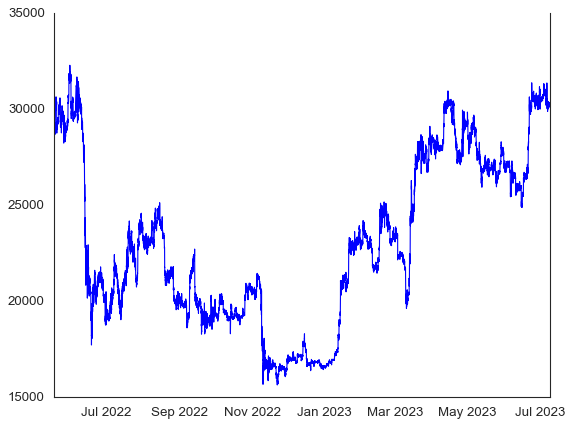

In [48]:
plt.plot(OHLCV['close'])

# Data prepocessing

Преобразуем наш датасет. Попробуем предоставить модели полную картину, происходящую на графике биржи, которые видят трейдеры, прогнозирующие цену с помощью технического анализа. Наш датасет будет состоять из следующих данных:

close - цена закрытия свечи;

low - цена низшей точки свечи;

high - цена высшей точки свечи;

open - цена открытия свечи;

close_diff - разница между ценами закрытия соседних свечей;

low_diff - разница между ценами низших точек соседних свечей;

high_diff - разница между ценами высших точек соседних свечей;

open_diff - разница между ценами открытия соседних свечей;

color_of_candle - цвет свечи(красный или зеленый, красный цвет - цена закрытия свечи ниже цены открытия, зеленый цвет - цена закрытия свечи выше цены открытия)

number_candle_trend - порядковый номер свечи в тренде(обозначает порядковый номер свечи в последовательности свечей одинакового цвета)

SMA_200 - 200-пятнадцатиминутная скользящая средняя

EMA_200 - 200-пятнадцатиминутная скользящая экспоненциальная

SMA_50 - 50-пятнадцатиминутная скользящая средняя

EMA_50 - 50-пятнадцатиминутная скользящая экспоненциальная

RSI - индекс относительной силы

MACD - линия MACD, является результатом взятия более долгосрочной EMA и вычитания ее из более краткосрочной EMA.Наиболее часто используемые значения - 26  для долгосрочной EMA и 12  для краткосрочной EMA

Signal - Сигнальная линия представляет собой EMA линии MACD, описанной в MACD. Трейдер может выбрать, какую EMA длины периода использовать для сигнальной линии, однако 9 является наиболее распространенной.

Histogram - С течением времени разница между линией MACD и сигнальной линией будет постоянно меняться. Гистограмма MACD учитывает это различие и отображает его в виде легко читаемой гистограммы. Разница между двумя линиями колеблется вокруг нулевой линии.

width_open_close - разница между ценой открытия и закрытия свечи

width_open_high - разница между ценой открытия и высшей ценой свечи

width_open_low - разница между ценой открытия и низшей ценой свечи

In [49]:
columns = {}
columns['close'] = list(OHLCV['close'].values)

SMA и EMA

In [50]:
SMA_200 = OHLCV['close'].rolling(window = 200).mean()
EMA_200 = OHLCV['close'].ewm(span=200).mean()
SMA_50 = OHLCV['close'].rolling(window = 50).mean()
EMA_50 = OHLCV['close'].ewm(span=50).mean()

SMA_200 = SMA_200.dropna()
EMA_200 = EMA_200.dropna()
SMA_50 = SMA_50.dropna()
EMA_50 = EMA_50.dropna()

columns['SMA_200'] = list(SMA_200.values)
columns['EMA_200'] = list(EMA_200.values)
columns['SMA_50'] = list(SMA_50.values)
columns['EMA_50'] = list(EMA_50.values)

RSI

In [51]:
def calculate_rsi(data, window=14):
    close = data['close']
    delta = close.diff()
    delta = delta[1:]

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    roll_up = up.rolling(window).mean()
    roll_down = np.abs(down.rolling(window).mean())

    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    return rsi

rsi = calculate_rsi(OHLCV)
rsi = rsi.dropna()
rsi

2022-05-18 11:30:00    51.935298
2022-05-18 11:45:00    52.320917
2022-05-18 12:00:00    50.000000
2022-05-18 12:15:00    49.138859
2022-05-18 12:30:00    42.048055
                         ...    
2023-07-08 22:45:00    46.883348
2023-07-08 23:00:00    42.023346
2023-07-08 23:15:00    33.750000
2023-07-08 23:30:00    30.744102
2023-07-08 23:45:00    30.434783
Name: close, Length: 39986, dtype: float64

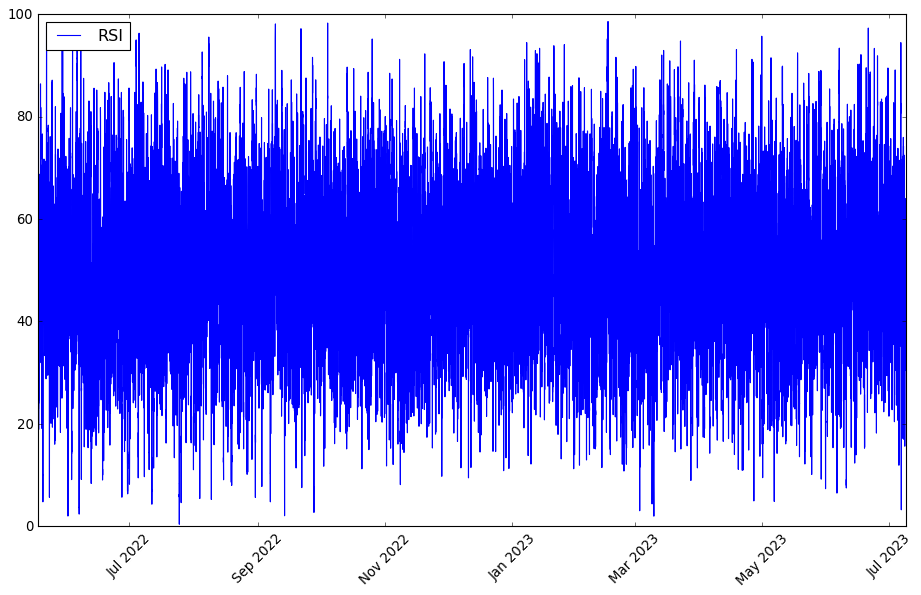

In [52]:
plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(rsi, label='RSI', color = 'blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()
columns['RSI'] = list(rsi.values)

MACD

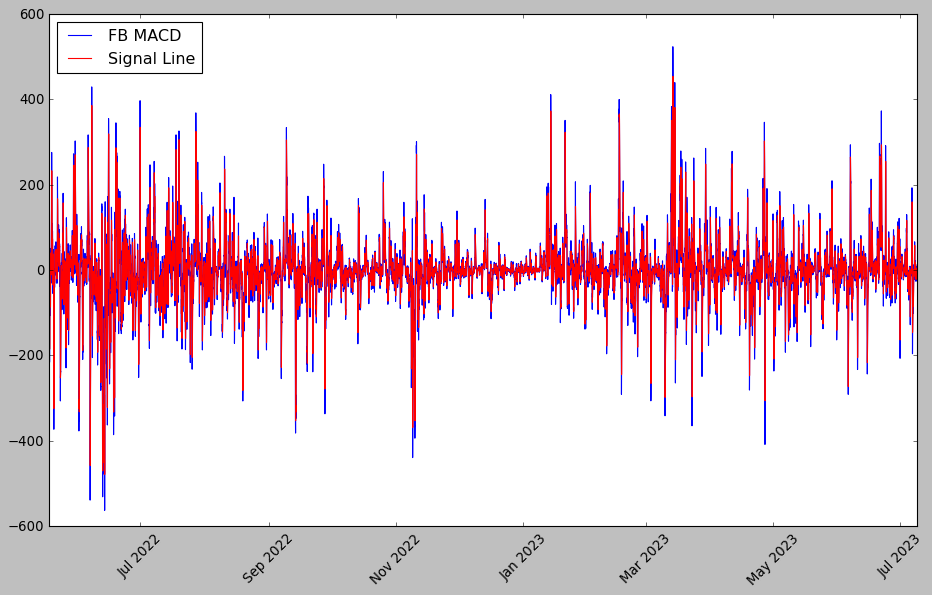

In [53]:
def calculate_macd(data, fast=12, slow=26, signal=9):
    close = data['close']
    exp1 = close.ewm(span=fast, min_periods=fast).mean()
    exp2 = close.ewm(span=slow, min_periods=slow).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, min_periods=signal).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

macd, signal_line, histogram = calculate_macd(OHLCV)

plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(OHLCV.index, macd, label='FB MACD', color = 'blue')
plt.plot(OHLCV.index, signal_line, label='Signal Line', color='red')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [54]:
macd = macd.dropna()
signal_line = signal_line.dropna()
histogram = histogram.dropna()

columns['macd'] = list(macd.values)
columns['signal_line'] = list(signal_line.values)
columns['histogram'] = list(histogram.values)

close_diff low_diff open_diff high_diff

In [55]:
def difference(dataset, interval=1):
 diff = list()
 for i in range(interval, len(dataset)):
     value = dataset[i] - dataset[i - interval]
     diff.append(value)
 return diff
# df1 = df[1:]
def difference_for_every_column(df, df1): 
    for column in df.columns.values:
        diff = difference(df[column])
        df1[column+'_diff'] = diff
    return df1

In [56]:
diff_df = pd.DataFrame()
diff_df = difference_for_every_column(OHLCV[['close', 'low', 'open', 'high']] , diff_df) 
diff_df  

,close_diff,low_diff,open_diff,high_diff
0,52.5,-3.0,-18.5,101.0
1,-9.5,60.0,52.5,-44.0
2,-35.5,-19.0,-9.5,13.5
3,89.0,-12.5,-35.5,77.0
4,47.5,129.0,89.0,40.5
...,...,...,...,...
39994,-8.2,-21.3,4.2,-8.4
39995,-14.8,-0.4,-8.2,-8.3
39996,-71.8,-145.1,-14.8,-11.9
39997,10.6,35.0,-71.8,-64.0


In [57]:
columns['close_diff'] = list(diff_df['close_diff'].values)
columns['low_diff'] = list(diff_df['low_diff'].values)
columns['open_diff'] = list(diff_df['open_diff'].values)
columns['high_diff'] = list(diff_df['high_diff'].values)

width_open_close, width_open_high, width_open_low

In [58]:
close_values = OHLCV['close'].values
low_values = OHLCV['low'].values
open_values = OHLCV['open'].values
high_values = OHLCV['high'].values
width_open_close = np.zeros(shape= len(OHLCV))
width_open_high = np.zeros(shape=len(OHLCV))
width_open_low = np.zeros(shape=len(OHLCV))
for i in range(len(OHLCV)):
    width_open_close[i] = close_values[i] - open_values[i] 
    width_open_high[i] = high_values[i] - open_values[i]
    width_open_low[i] = open_values[i] - low_values[i]

columns['width_open_close'] = list(width_open_close)
columns['width_open_high'] = list(width_open_high)
columns['width_open_low'] = list(width_open_low)

color_of_candle, number_candle_trend

In [59]:
color_of_candle = []
number_candle_trend = np.zeros(shape=len(OHLCV))
for i in range(len(OHLCV)):
    if width_open_close[i] > 0:
        color_of_candle.append('green')
    else:
        color_of_candle.append('red')
        
number_candle_trend[0] = 1
cnt = 1
for i in range(1,len(OHLCV)):
    if (color_of_candle[i] == color_of_candle[i - 1]):
        cnt = cnt + 1
        number_candle_trend[i] = cnt
    else:
        cnt = 1
        number_candle_trend[i] = cnt

columns['color_of_candle'] = color_of_candle
columns['number_candle_trend'] = number_candle_trend

Соберем все признаки в один датасет

In [60]:
for key, value in columns.items():
    print(key, " -> ", len(value))

close  ->  40000
SMA_200  ->  39801
EMA_200  ->  40000
SMA_50  ->  39951
EMA_50  ->  40000
RSI  ->  39986
macd  ->  39975
signal_line  ->  39967
histogram  ->  39967
close_diff  ->  39999
low_diff  ->  39999
open_diff  ->  39999
high_diff  ->  39999
width_open_close  ->  40000
width_open_high  ->  40000
width_open_low  ->  40000
color_of_candle  ->  40000
number_candle_trend  ->  40000


In [61]:
df_candles = pd.DataFrame({})
for key, value in columns.items():
    df_candles[key] = value[-(len(SMA_200)):]
    
df_candles

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend
0,30180.5,29594.9225,29760.195975,30204.200,30122.733561,41.001565,-27.127963,-11.763803,-15.364161,22.5,41.0,68.0,27.5,22.5,27.5,52.0,green,3.0
1,30147.5,29596.6475,29764.645988,30205.080,30123.705107,33.656958,-26.053765,-14.621795,-11.431970,-33.0,20.0,22.5,-5.0,-33.0,0.0,54.5,red,1.0
2,29986.5,29597.3050,29767.191109,30201.370,30118.322850,27.844712,-37.758551,-19.249146,-18.509405,-161.0,-172.0,-33.0,-33.0,-161.0,0.0,193.5,red,2.0
3,29935.5,29597.7550,29769.119024,30193.920,30111.151195,29.524485,-50.567046,-25.512726,-25.054320,-51.0,-113.5,-161.0,-160.5,-51.0,0.5,146.0,red,3.0
4,30003.5,29598.7225,29771.799736,30189.880,30106.928373,35.267275,-54.601428,-31.330467,-23.270961,68.0,25.5,-51.0,18.0,68.0,69.5,69.5,green,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39796,30187.9,30201.8715,30271.242551,30205.764,30213.438528,46.883348,-0.800033,2.850740,-3.650774,-8.2,-21.3,4.2,-8.4,-8.2,0.1,25.6,red,1.0
39797,30173.1,30201.4945,30270.266008,30205.842,30211.856625,42.023346,-3.581549,1.564282,-5.145832,-14.8,-0.4,-8.2,-8.3,-14.8,0.0,17.8,red,2.0
39798,30101.3,30200.8815,30268.584755,30204.500,30207.521071,33.750000,-11.447619,-1.038098,-10.409521,-71.8,-145.1,-14.8,-11.9,-71.8,2.9,148.1,red,3.0
39799,30111.9,30200.2130,30267.025702,30203.046,30203.771225,30.744102,-16.634454,-4.157369,-12.477085,10.6,35.0,-71.8,-64.0,10.6,10.7,41.3,green,1.0


In [62]:
percent = []
for index, row in df_candles.iterrows():
    percent.append(abs(row['close_diff'])/row['close'])

change_percent_mean = np.array(percent).mean()

In [63]:
#делаем сдвиг по целевой переменной, чтобы для каждой строки целевой переменной стало значения закрытия цены на следующей свече
df_close_next = df_candles['close'][1:].values
df_candles = df_candles[:-1]
df_candles['close_next'] = df_close_next
df_candles

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend,close_next
0,30180.5,29594.9225,29760.195975,30204.200,30122.733561,41.001565,-27.127963,-11.763803,-15.364161,22.5,41.0,68.0,27.5,22.5,27.5,52.0,green,3.0,30147.5
1,30147.5,29596.6475,29764.645988,30205.080,30123.705107,33.656958,-26.053765,-14.621795,-11.431970,-33.0,20.0,22.5,-5.0,-33.0,0.0,54.5,red,1.0,29986.5
2,29986.5,29597.3050,29767.191109,30201.370,30118.322850,27.844712,-37.758551,-19.249146,-18.509405,-161.0,-172.0,-33.0,-33.0,-161.0,0.0,193.5,red,2.0,29935.5
3,29935.5,29597.7550,29769.119024,30193.920,30111.151195,29.524485,-50.567046,-25.512726,-25.054320,-51.0,-113.5,-161.0,-160.5,-51.0,0.5,146.0,red,3.0,30003.5
4,30003.5,29598.7225,29771.799736,30189.880,30106.928373,35.267275,-54.601428,-31.330467,-23.270961,68.0,25.5,-51.0,18.0,68.0,69.5,69.5,green,1.0,30143.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39795,30196.1,30202.4320,30272.080165,30205.654,30214.480917,54.090909,1.254920,3.763434,-2.508514,4.2,7.1,-0.1,8.3,4.2,12.7,0.1,green,1.0,30187.9
39796,30187.9,30201.8715,30271.242551,30205.764,30213.438528,46.883348,-0.800033,2.850740,-3.650774,-8.2,-21.3,4.2,-8.4,-8.2,0.1,25.6,red,1.0,30173.1
39797,30173.1,30201.4945,30270.266008,30205.842,30211.856625,42.023346,-3.581549,1.564282,-5.145832,-14.8,-0.4,-8.2,-8.3,-14.8,0.0,17.8,red,2.0,30101.3
39798,30101.3,30200.8815,30268.584755,30204.500,30207.521071,33.750000,-11.447619,-1.038098,-10.409521,-71.8,-145.1,-14.8,-11.9,-71.8,2.9,148.1,red,3.0,30111.9


In [64]:
df_candles_supervised = df_candles.copy()
directions = []
for index, row in df_candles_supervised.iterrows():
    if row['close_next'] > row['close']:
        directions.append('long')
    else:
        directions.append('short')
df_candles_supervised['direction'] = directions
df_candles_supervised  

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend,close_next,direction
0,30180.5,29594.9225,29760.195975,30204.200,30122.733561,41.001565,-27.127963,-11.763803,-15.364161,22.5,41.0,68.0,27.5,22.5,27.5,52.0,green,3.0,30147.5,short
1,30147.5,29596.6475,29764.645988,30205.080,30123.705107,33.656958,-26.053765,-14.621795,-11.431970,-33.0,20.0,22.5,-5.0,-33.0,0.0,54.5,red,1.0,29986.5,short
2,29986.5,29597.3050,29767.191109,30201.370,30118.322850,27.844712,-37.758551,-19.249146,-18.509405,-161.0,-172.0,-33.0,-33.0,-161.0,0.0,193.5,red,2.0,29935.5,short
3,29935.5,29597.7550,29769.119024,30193.920,30111.151195,29.524485,-50.567046,-25.512726,-25.054320,-51.0,-113.5,-161.0,-160.5,-51.0,0.5,146.0,red,3.0,30003.5,long
4,30003.5,29598.7225,29771.799736,30189.880,30106.928373,35.267275,-54.601428,-31.330467,-23.270961,68.0,25.5,-51.0,18.0,68.0,69.5,69.5,green,1.0,30143.5,long
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39795,30196.1,30202.4320,30272.080165,30205.654,30214.480917,54.090909,1.254920,3.763434,-2.508514,4.2,7.1,-0.1,8.3,4.2,12.7,0.1,green,1.0,30187.9,short
39796,30187.9,30201.8715,30271.242551,30205.764,30213.438528,46.883348,-0.800033,2.850740,-3.650774,-8.2,-21.3,4.2,-8.4,-8.2,0.1,25.6,red,1.0,30173.1,short
39797,30173.1,30201.4945,30270.266008,30205.842,30211.856625,42.023346,-3.581549,1.564282,-5.145832,-14.8,-0.4,-8.2,-8.3,-14.8,0.0,17.8,red,2.0,30101.3,short
39798,30101.3,30200.8815,30268.584755,30204.500,30207.521071,33.750000,-11.447619,-1.038098,-10.409521,-71.8,-145.1,-14.8,-11.9,-71.8,2.9,148.1,red,3.0,30111.9,long


Кодируем категориальные переменнные

In [65]:


number_candle_trend_encoder = LabelEncoder()
df_candles_supervised["color_of_candle"] = number_candle_trend_encoder.fit_transform(df_candles_supervised["color_of_candle"])
color_of_candle_encoder = LabelEncoder()
df_candles_supervised["number_candle_trend"] = color_of_candle_encoder.fit_transform(df_candles_supervised["number_candle_trend"])
direction_encoder = LabelEncoder()
df_candles_supervised["direction"] = direction_encoder.fit_transform(df_candles_supervised["direction"])

df_candles_supervised.drop(columns = ['close_next'], inplace = True)

In [66]:
df_candles_supervised['direction'].value_counts()

0    19951
1    19849
Name: direction, dtype: int64

In [67]:
df_candles_supervised

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend,direction
0,30180.5,29594.9225,29760.195975,30204.200,30122.733561,41.001565,-27.127963,-11.763803,-15.364161,22.5,41.0,68.0,27.5,22.5,27.5,52.0,0,2,1
1,30147.5,29596.6475,29764.645988,30205.080,30123.705107,33.656958,-26.053765,-14.621795,-11.431970,-33.0,20.0,22.5,-5.0,-33.0,0.0,54.5,1,0,1
2,29986.5,29597.3050,29767.191109,30201.370,30118.322850,27.844712,-37.758551,-19.249146,-18.509405,-161.0,-172.0,-33.0,-33.0,-161.0,0.0,193.5,1,1,1
3,29935.5,29597.7550,29769.119024,30193.920,30111.151195,29.524485,-50.567046,-25.512726,-25.054320,-51.0,-113.5,-161.0,-160.5,-51.0,0.5,146.0,1,2,0
4,30003.5,29598.7225,29771.799736,30189.880,30106.928373,35.267275,-54.601428,-31.330467,-23.270961,68.0,25.5,-51.0,18.0,68.0,69.5,69.5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39795,30196.1,30202.4320,30272.080165,30205.654,30214.480917,54.090909,1.254920,3.763434,-2.508514,4.2,7.1,-0.1,8.3,4.2,12.7,0.1,0,0,1
39796,30187.9,30201.8715,30271.242551,30205.764,30213.438528,46.883348,-0.800033,2.850740,-3.650774,-8.2,-21.3,4.2,-8.4,-8.2,0.1,25.6,1,0,1
39797,30173.1,30201.4945,30270.266008,30205.842,30211.856625,42.023346,-3.581549,1.564282,-5.145832,-14.8,-0.4,-8.2,-8.3,-14.8,0.0,17.8,1,1,1
39798,30101.3,30200.8815,30268.584755,30204.500,30207.521071,33.750000,-11.447619,-1.038098,-10.409521,-71.8,-145.1,-14.8,-11.9,-71.8,2.9,148.1,1,2,0


In [68]:
df_candles_supervised.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39800 entries, 0 to 39799
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   close                39800 non-null  float64
 1   SMA_200              39800 non-null  float64
 2   EMA_200              39800 non-null  float64
 3   SMA_50               39800 non-null  float64
 4   EMA_50               39800 non-null  float64
 5   RSI                  39800 non-null  float64
 6   macd                 39800 non-null  float64
 7   signal_line          39800 non-null  float64
 8   histogram            39800 non-null  float64
 9   close_diff           39800 non-null  float64
 10  low_diff             39800 non-null  float64
 11  open_diff            39800 non-null  float64
 12  high_diff            39800 non-null  float64
 13  width_open_close     39800 non-null  float64
 14  width_open_high      39800 non-null  float64
 15  width_open_low       39800 non-null 

Преобразованный датасет имеет 39820 строк и 19 колонок

# Feature Selection

Определим наилучший метод для отбора признаков

Функция разбиения датасета и нормализации

In [69]:
def split_normalization_for_VIF_RFE_PCA(dataset):
    split = 0.8
    i_split = int(len(dataset) * split)
    train = dataset[:i_split]
    test = dataset[i_split:]
    i_split_val = int(len(train) * split)
    val = train[i_split_val:]
    train = train[:i_split_val]    
    
    scaler_1 = MinMaxScaler(feature_range = (0,1))
    scaler_2 = MinMaxScaler(feature_range = (-1,1))
    
    
    #scaler_1
    features_scaler_1 = []


    #scaler_2
    features_scaler_2 = []

    
    columns_dataset = list(dataset.columns.values)
    columns_dataset.remove('color_of_candle')
    columns_dataset.remove('number_candle_trend')
    columns_dataset.remove('direction')

    for column in columns_dataset:
        if any(x < 0 for x in list(dataset[column].values)):
            features_scaler_2.append(column)
        else:
            features_scaler_1.append(column)
    
    

    # train

    train_1 = train.loc[:, features_scaler_1].values
    train_2 = train.loc[:, features_scaler_2].values


    train_1 = scaler_1.fit_transform(train_1)
    train_1 = pd.DataFrame(train_1, columns=features_scaler_1)

    train_2 = scaler_2.fit_transform(train_2)
    train_2 = pd.DataFrame(train_2, columns=features_scaler_2)

    train_categorial = train.loc[:,['color_of_candle', 'number_candle_trend', 'direction']].reset_index()
    train_std = pd.concat([train_1, train_2, train_categorial], axis=1)
    
    # test
    test_1 = test.loc[:, features_scaler_1].values
    test_2 = test.loc[:, features_scaler_2].values


    test_1 = scaler_1.transform(test_1)
    test_1 = pd.DataFrame(test_1, columns=features_scaler_1)

    test_2 = scaler_2.transform(test_2)
    test_2 = pd.DataFrame(test_2, columns=features_scaler_2)

    test_categorial = test.loc[:,['color_of_candle', 'number_candle_trend', 'direction']].reset_index()
    test_std = pd.concat([test_1, test_2, test_categorial], axis=1)
    
    # val
    val_1 = val.loc[:, features_scaler_1].values
    val_2 = val.loc[:, features_scaler_2].values


    val_1 = scaler_1.transform(val_1)
    val_1 = pd.DataFrame(val_1, columns=features_scaler_1)

    val_2 = scaler_2.transform(val_2)
    val_2 = pd.DataFrame(val_2, columns=features_scaler_2)

    val_categorial = val.loc[:,['color_of_candle', 'number_candle_trend', 'direction']].reset_index()
    val_std = pd.concat([val_1, val_2, val_categorial], axis=1)



    train_X = train_std.drop(['direction', 'index'],axis=1)
    train_y = train_std['direction']
    
    test_X = test_std.drop(['direction', 'index'],axis=1)
    test_y = test_std['direction']


    val_X = val_std.drop(['direction', 'index'],axis=1)
    val_y = val_std['direction']

    return train_X, train_y, test_X, test_y, val_X, val_y

Функция создания последовательностей

In [70]:
# multivariate output data prep
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(df, n_steps):

    columns = df.columns.values

    arrays = []
    for column in columns:
        values = df[column].values
        a = values.reshape(len(values), 1)
        arrays.append(a)

    sequences = hstack((arrays))

    X, y = list(), list()
    for i in range(len(sequences)):

        end_ix = i + n_steps

        if end_ix > len(sequences)-1:
            break

        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X)

Метрики

In [71]:
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
def metrics(real, forecast):
    
    print('balanced_accuracy:', balanced_accuracy_score(real, forecast))
    print('precision:', precision_score(real, forecast))
    print('recall:', recall_score(real, forecast))
    print('f1-score:', f1_score(real, forecast))
    cm = confusion_matrix(real, forecast)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

VIF

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_creation(X):
    vif_df = pd.DataFrame()
    vif_df['Feature Name'] = X.columns
    vif_df['Vif Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_df

vif_df = df_candles_supervised.drop(['direction'], axis =1)
vif_df = vif_creation(vif_df)
vif_df

,Feature Name,Vif Factor
0,close,4.307615e+05
1,SMA_200,6.629380e+04
2,EMA_200,8.467419e+04
3,SMA_50,7.262505e+05
4,EMA_50,1.137434e+06
5,RSI,1.606787e+01
6,macd,inf
7,signal_line,inf
8,histogram,inf
9,close_diff,inf


Выберем признаки со значением меньше 6

In [33]:
columns_vif = []
for index, row in vif_df.iterrows():
    if (row['Vif Factor'] < 6):
      columns_vif.append(row['Feature Name'])

columns_vif.append('direction')


df_candles_VIF = df_candles_supervised[columns_vif]

df_candles_VIF


,low_diff,open_diff,high_diff,color_of_candle,number_candle_trend,direction
0,41.0,68.0,27.5,0,2,1
1,20.0,22.5,-5.0,1,0,1
2,-172.0,-33.0,-33.0,1,1,1
3,-113.5,-161.0,-160.5,1,2,0
4,25.5,-51.0,18.0,0,0,0
...,...,...,...,...,...,...
39795,7.1,-0.1,8.3,0,0,1
39796,-21.3,4.2,-8.4,1,0,1
39797,-0.4,-8.2,-8.3,1,1,1
39798,-145.1,-14.8,-11.9,1,2,0


In [34]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_VIF)

n_steps = 10
Train_X_sq = split_sequences(train_X, n_steps)
Test_X_sq = split_sequences(test_X, n_steps)
Val_X_sq = split_sequences(val_X, n_steps)


train_y_sq = train_y[n_steps - 1: -1]
val_y_sq = val_y[n_steps - 1: -1]
test_y_sq = test_y[n_steps - 1: -1]

# design network
model = Sequential()
model.add(LSTM(256, input_shape=(Train_X_sq.shape[1], Train_X_sq.shape[2]), activation = 'elu',return_sequences=True))
model.add(LSTM(128, activation = 'elu',return_sequences=True))
model.add(LSTM(56, activation = 'elu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(Train_X_sq, train_y_sq, batch_size=72, epochs=20, validation_data=(Val_X_sq, val_y_sq), callbacks = [callback])

yhat = model.predict(Test_X_sq)
yhat = yhat.reshape(yhat.shape[0])

for i in range(len(yhat)):
    if (yhat[i]>0.5):
        yhat[i] = 1
    else:
        yhat[i] = 0
        
metrics(yhat, test_y_sq)


ValueError: Found array with 0 feature(s) (shape=(25472, 0)) while a minimum of 1 is required by MinMaxScaler.

In [39]:
pd.Series(test_y_sq).value_counts()

0    1934
1    1856
Name: direction, dtype: int64

balanced_accuracy: 0.5827455280428129
precision: 0.017241379310344827
recall: 0.6530612244897959
f1-score: 0.033595800524934376


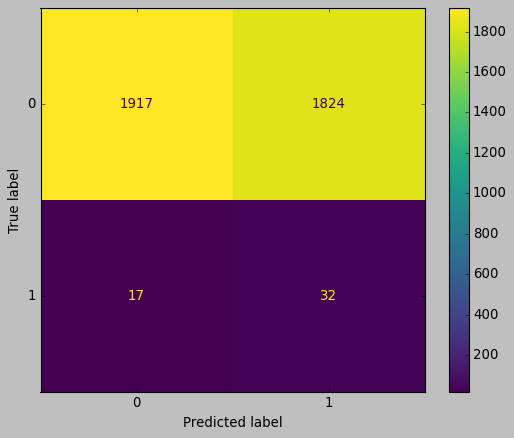

In [37]:
metrics(yhat, test_y_sq)

RFE

In [72]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_supervised)


Train_yhat_metrics_RFE={}
Train_yhat_metrics_RFE['balanced_acc'] = []
Train_yhat_metrics_RFE['precision'] = []
Train_yhat_metrics_RFE['recall'] = []

Test_yhat_metrics_RFE={}
Test_yhat_metrics_RFE['balanced_acc'] = []
Test_yhat_metrics_RFE['precision'] = []
Test_yhat_metrics_RFE['recall'] = []
 
m=train_X.shape[1]-1

features_rfe = []

for i in range(m):

    train_y_1 = train_y.copy()
    
    rfe = RFE(LinearRegression(),n_features_to_select=train_X.shape[1]-i)            
    rfe = rfe.fit(train_X, train_y_1)
    
    Train_X_std_rfe = train_X.loc[:,rfe.support_]
    Test_X_std_rfe = test_X.loc[:,rfe.support_]
    Val_X_std_rfe = val_X.loc[:,rfe.support_]
    
    features_rfe.append(rfe.support_)
    
    n_steps = 10
    Train_X_std_rfe = split_sequences(Train_X_std_rfe, n_steps)
    Test_X_std_rfe = split_sequences(Test_X_std_rfe, n_steps)
    Val_X_std_rfe = split_sequences(Val_X_std_rfe, n_steps)


    train_y_rfe = train_y[n_steps - 1: -1]
    val_y_rfe = val_y[n_steps - 1: -1]
    test_y_rfe = test_y[n_steps - 1: -1]
    
    # design network
    model = Sequential()
    model.add(LSTM(128, input_shape=(Train_X_std_rfe.shape[1], Train_X_std_rfe.shape[2]), activation = 'relu',return_sequences=True))
    model.add(LSTM(56, activation = 'relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
    # fit network
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
    model.fit(Train_X_std_rfe, train_y_rfe, batch_size=72, epochs=20, validation_data=(Val_X_std_rfe, val_y_rfe), callbacks = [callback])
    # plot history

    yhat_train = model.predict(Train_X_std_rfe)
    yhat_test = model.predict(Test_X_std_rfe)
    yhat_train = yhat_train.reshape(yhat_train.shape[0])
    yhat_test = yhat_test.reshape(yhat_test.shape[0])

    for i in range(len(yhat_train)):
        if (yhat_train[i]>0.5):
            yhat_train[i] = 1
        else:
            yhat_train[i] = 0

    for i in range(len(yhat_test)):
        if (yhat_test[i]>0.5):
            yhat_test[i] = 1
        else:
            yhat_test[i] = 0

    Train_yhat_metrics_RFE['balanced_acc'].append(balanced_accuracy_score(yhat_train, train_y_rfe))
    Train_yhat_metrics_RFE['precision'].append(precision_score(yhat_train, train_y_rfe))
    Train_yhat_metrics_RFE['recall'].append(recall_score(yhat_train, train_y_rfe))


    Test_yhat_metrics_RFE['balanced_acc'].append(balanced_accuracy_score(yhat_test, test_y_rfe))
    Test_yhat_metrics_RFE['precision'].append(precision_score(yhat_test, test_y_rfe))
    Test_yhat_metrics_RFE['recall'].append(recall_score(yhat_test, test_y_rfe))

    
    


Epoch 1/20
 89/354 [======>.......................] - ETA: 7s - loss: 0.6936 - binary_accuracy: 0.5053

KeyboardInterrupt: 

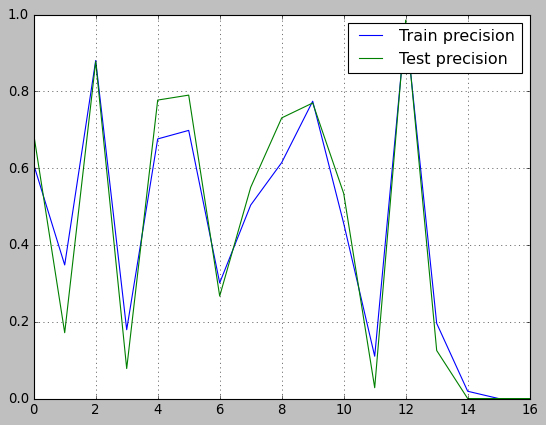

In [36]:
plt.plot(Train_yhat_metrics_RFE['precision'], label='Train precision')
plt.plot(Test_yhat_metrics_RFE['precision'], label='Test precision')
plt.legend()
plt.grid()
plt.show()

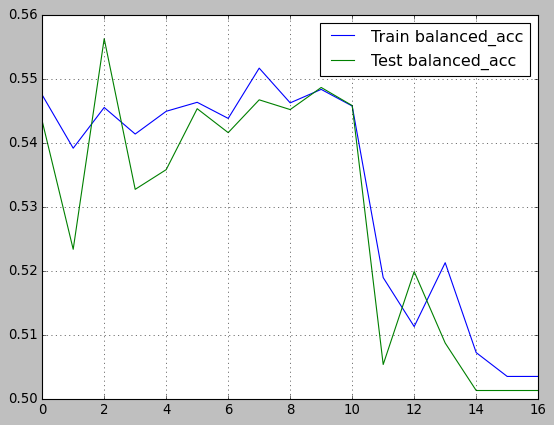

In [37]:
plt.plot(Train_yhat_metrics_RFE['balanced_acc'], label='Train balanced_acc')
plt.plot(Test_yhat_metrics_RFE['balanced_acc'], label='Test balanced_acc')
plt.legend()
plt.grid()
plt.show()

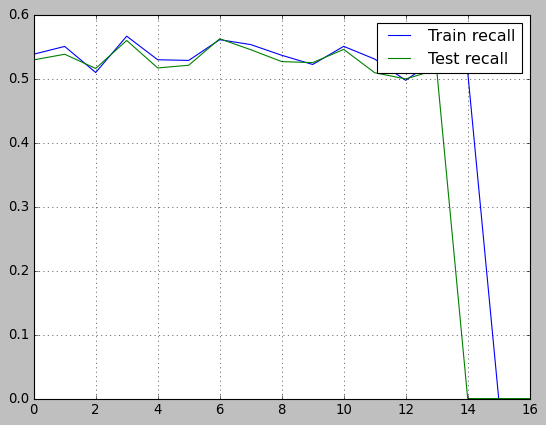

In [38]:
plt.plot(Train_yhat_metrics_RFE['recall'], label='Train recall')
plt.plot(Test_yhat_metrics_RFE['recall'], label='Test recall')
plt.legend()
plt.grid()
plt.show()

Сравнив все показатели самым лучшим показателем будет число 2 для RFE

Epoch 1/20
1061/1061 [==============================] - 18s 15ms/step - loss: 0.6925 - binary_accuracy: 0.5152 - val_loss: 0.6909 - val_binary_accuracy: 0.5379
Epoch 2/20
1061/1061 [==============================] - 15s 14ms/step - loss: 0.6908 - binary_accuracy: 0.5303 - val_loss: 0.6896 - val_binary_accuracy: 0.5315
Epoch 3/20
1061/1061 [==============================] - 14s 14ms/step - loss: 0.6900 - binary_accuracy: 0.5375 - val_loss: 0.6894 - val_binary_accuracy: 0.5359
Epoch 4/20
249/249 [==============================] - 1s 6ms/step
balanced_accuracy: 0.5390918972629074
precision: 0.5271133832389995
recall: 0.7281210592686003
f1-score: 0.6115229824189792


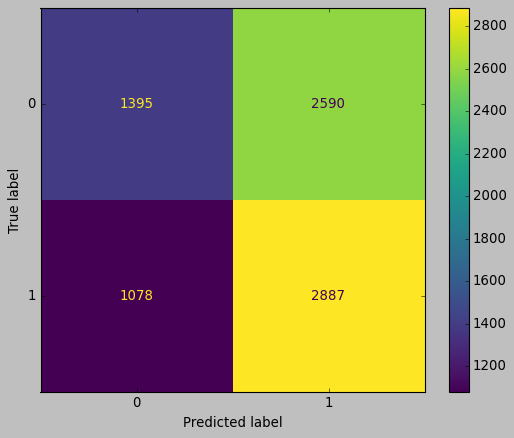

In [39]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_supervised)

rfe = RFE(LinearRegression(),n_features_to_select=train_X.shape[1]-2)            
rfe = rfe.fit(train_X, train_y)

Train_X_std_rfe = train_X.loc[:,rfe.support_]
Test_X_std_rfe = test_X.loc[:,rfe.support_]
Val_X_std_rfe = val_X.loc[:,rfe.support_]


n_steps = 10
Train_X_std_rfe = split_sequences(Train_X_std_rfe, n_steps)
Test_X_std_rfe = split_sequences(Test_X_std_rfe, n_steps)
Val_X_std_rfe = split_sequences(Val_X_std_rfe, n_steps)


train_y_rfe = train_y[n_steps - 1: -1]
val_y_rfe = val_y[n_steps - 1: -1]
test_y_rfe = test_y[n_steps - 1: -1]

# design network
model = Sequential()
model.add(LSTM(128, input_shape=(Train_X_std_rfe.shape[1], Train_X_std_rfe.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(Train_X_std_rfe, train_y_rfe, batch_size=24, epochs=20, validation_data=(Val_X_std_rfe, val_y_rfe), callbacks = [callback])
# plot history

yhat_train = model.predict(Train_X_std_rfe)
yhat_test = model.predict(Test_X_std_rfe)

yhat_train = model.predict(Train_X_std_rfe)
yhat_test = model.predict(Test_X_std_rfe)
yhat_train = yhat_train.reshape(yhat_train.shape[0])
yhat_test = yhat_test.reshape(yhat_test.shape[0])

for i in range(len(yhat_train)):
    if (yhat_train[i]>0.5):
        yhat_train[i] = 1
    else:
        yhat_train[i] = 0

for i in range(len(yhat_test)):
    if (yhat_test[i]>0.5):
        yhat_test[i] = 1
    else:
        yhat_test[i] = 0

metrics(test_y_rfe, yhat_test)

In [40]:
pd.Series(list(yhat_test)).value_counts()

1.0    5477
0.0    2473
dtype: int64

In [41]:
pd.Series(test_y_rfe).value_counts()

0    3985
1    3965
Name: direction, dtype: int64

PCA

In [85]:
from sklearn.decomposition import PCA

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_supervised)


Train_yhat_metrics_PCA={}
Train_yhat_metrics_PCA['balanced_acc'] = []
Train_yhat_metrics_PCA['precision'] = []
Train_yhat_metrics_PCA['recall'] = []

Test_yhat_metrics_PCA={}
Test_yhat_metrics_PCA['balanced_acc'] = []
Test_yhat_metrics_PCA['precision'] = []
Test_yhat_metrics_PCA['recall'] = []
 
m=train_X.shape[1]-1

features_pca = []

for i in range(m):
    
    pca = PCA(n_components=train_X.shape[1]-i)           
    
    Train_X_std_pca = pca.fit_transform(train_X)
    Val_X_std_pca = pca.fit_transform(val_X)
    Test_X_std_pca = pca.fit_transform(test_X)
    
    
    Train_X_std_pca = pd.DataFrame(Train_X_std_pca) 
    Test_X_std_pca = pd.DataFrame(Test_X_std_pca)
    Val_X_std_pca = pd.DataFrame(Val_X_std_pca)


    n_steps = 10
    Train_X_std_pca = split_sequences(Train_X_std_pca, n_steps)
    Test_X_std_pca = split_sequences(Test_X_std_pca, n_steps)
    Val_X_std_pca = split_sequences(Val_X_std_pca, n_steps)

    train_y_pca = train_y[n_steps - 1: -1]
    val_y_pca = val_y[n_steps - 1: -1]
    test_y_pca = test_y[n_steps - 1: -1]
    
    # design network
    model = Sequential()
    model.add(LSTM(256, input_shape=(Train_X_std_pca.shape[1], Train_X_std_pca.shape[2]), activation = 'elu',return_sequences=True))
    model.add(LSTM(128, activation = 'elu',return_sequences=True))
    model.add(LSTM(56, activation = 'elu'))
    model.add(Dense(1))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
    # fit network

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
    model.fit(Train_X_std_pca, train_y_pca, batch_size=72, epochs=20, validation_data=(Val_X_std_pca, val_y_pca), callbacks = [callback])
    # plot history

    yhat_train = model.predict(Train_X_std_pca)
    yhat_test = model.predict(Test_X_std_pca)

    for i in range(len(yhat_train)):
        if (yhat_train[i]>0.5):
            yhat_train[i] = 1
        else:
            yhat_train[i] = 0

    for i in range(len(yhat_test)):
        if (yhat_test[i]>0.5):
            yhat_test[i] = 1
        else:
            yhat_test[i] = 0

    Train_yhat_metrics_PCA['balanced_acc'].append(balanced_accuracy_score(yhat_train, train_y_pca))
    Train_yhat_metrics_PCA['precision'].append(precision_score(yhat_train, train_y_pca))
    Train_yhat_metrics_PCA['recall'].append(recall_score(yhat_train, train_y_pca))


    Test_yhat_metrics_PCA['balanced_acc'].append(balanced_accuracy_score(yhat_test, test_y_pca))
    Test_yhat_metrics_PCA['precision'].append(precision_score(yhat_test, test_y_pca))
    Test_yhat_metrics_PCA['recall'].append(recall_score(yhat_test, test_y_pca))

Epoch 1/20
710/710 [==============================] - 140s 183ms/step - loss: 0.7711 - binary_accuracy: 0.5238 - val_loss: 0.9285 - val_binary_accuracy: 0.5001
Epoch 2/20
710/710 [==============================] - 108s 152ms/step - loss: 0.6892 - binary_accuracy: 0.5392 - val_loss: 0.8826 - val_binary_accuracy: 0.4950
Epoch 3/20
710/710 [==============================] - 119s 167ms/step - loss: 0.6880 - binary_accuracy: 0.5452 - val_loss: 0.8813 - val_binary_accuracy: 0.5067
Epoch 4/20
710/710 [==============================] - 119s 167ms/step - loss: 0.6879 - binary_accuracy: 0.5458 - val_loss: 0.7854 - val_binary_accuracy: 0.5009
Epoch 5/20
710/710 [==============================] - 118s 167ms/step - loss: 0.6874 - binary_accuracy: 0.5505 - val_loss: 0.8277 - val_binary_accuracy: 0.4953
Epoch 6/20
499/499 [==============================] - 20s 39ms/step
Epoch 1/20
710/710 [==============================] - 135s 177ms/step - loss: 0.7129 - binary_accuracy: 0.5237 - val_loss: 0.8059 - 

499/499 [==============================] - 20s 39ms/step
Epoch 1/20
710/710 [==============================] - 132s 173ms/step - loss: 0.7237 - binary_accuracy: 0.5260 - val_loss: 0.8684 - val_binary_accuracy: 0.4980
Epoch 2/20
710/710 [==============================] - 122s 172ms/step - loss: 0.6905 - binary_accuracy: 0.5431 - val_loss: 0.7661 - val_binary_accuracy: 0.4954
Epoch 3/20
710/710 [==============================] - 122s 171ms/step - loss: 0.6884 - binary_accuracy: 0.5452 - val_loss: 1.2106 - val_binary_accuracy: 0.4993
Epoch 4/20
710/710 [==============================] - 122s 171ms/step - loss: 0.6901 - binary_accuracy: 0.5466 - val_loss: 0.9790 - val_binary_accuracy: 0.5047
Epoch 5/20
710/710 [==============================] - 122s 172ms/step - loss: 0.6873 - binary_accuracy: 0.5473 - val_loss: 0.9103 - val_binary_accuracy: 0.4943
Epoch 6/20
710/710 [==============================] - 122s 172ms/step - loss: 0.6878 - binary_accuracy: 0.5493 - val_loss: 1.0136 - val_binary_

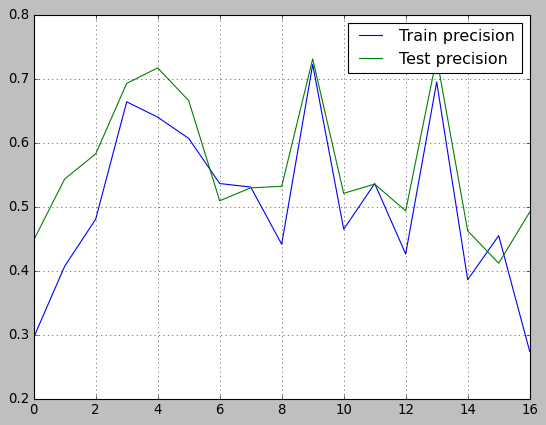

In [86]:
plt.plot(Train_yhat_metrics_PCA['precision'], label='Train precision')
plt.plot(Test_yhat_metrics_PCA['precision'], label='Test precision')
plt.legend()
plt.grid()
plt.show()

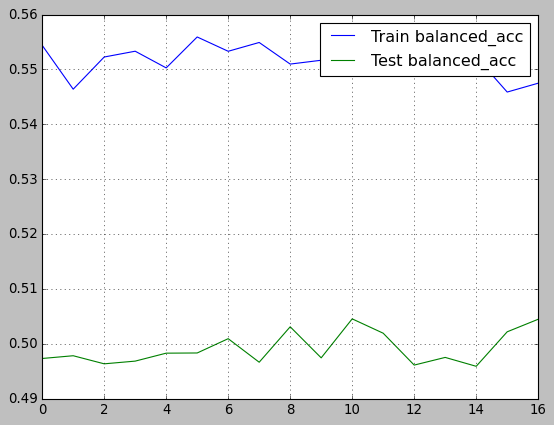

In [87]:
plt.plot(Train_yhat_metrics_PCA['balanced_acc'], label='Train balanced_acc')
plt.plot(Test_yhat_metrics_PCA['balanced_acc'], label='Test balanced_acc')
plt.legend()
plt.grid()
plt.show()

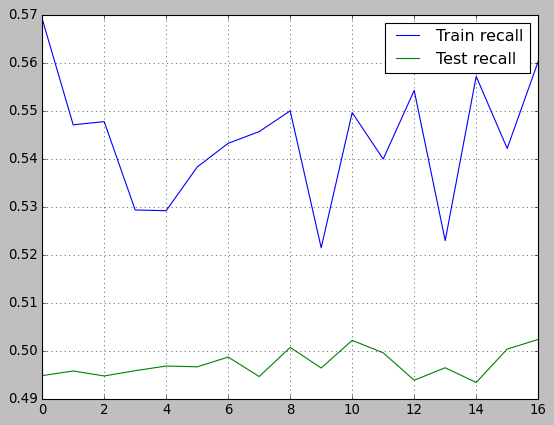

In [88]:
plt.plot(Train_yhat_metrics_PCA['recall'], label='Train recall')
plt.plot(Test_yhat_metrics_PCA['recall'], label='Test recall')
plt.legend()
plt.grid()
plt.show()

Для PCA наиболее оптимальным показателем стал 8


Epoch 1/20
710/710 [==============================] - 164s 214ms/step - loss: 0.7147 - binary_accuracy: 0.5222 - val_loss: 0.7920 - val_binary_accuracy: 0.5141
Epoch 2/20
710/710 [==============================] - 149s 210ms/step - loss: 0.6894 - binary_accuracy: 0.5449 - val_loss: 0.7702 - val_binary_accuracy: 0.4950
Epoch 3/20
710/710 [==============================] - 149s 210ms/step - loss: 0.6880 - binary_accuracy: 0.5478 - val_loss: 0.7434 - val_binary_accuracy: 0.4970
Epoch 4/20
499/499 [==============================] - 25s 50ms/step
balanced_accuracy: 0.49833562259608755
precision: 0.49645390070921985
recall: 0.6433337529900541


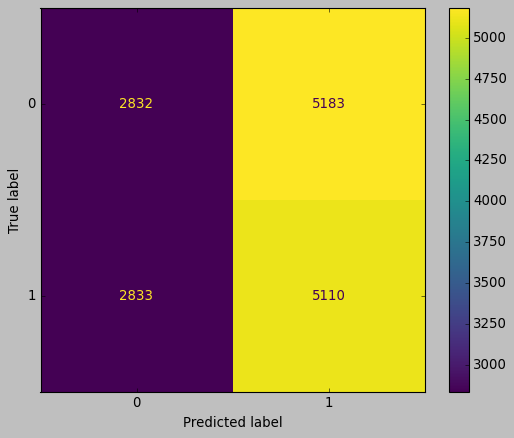

In [89]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_supervised)


pca = PCA(n_components=train_X.shape[1]-8)           

Train_X_std_pca = pca.fit_transform(train_X)
Val_X_std_pca = pca.fit_transform(val_X)
Test_X_std_pca = pca.fit_transform(test_X)


Train_X_std_pca = pd.DataFrame(Train_X_std_pca) 
Test_X_std_pca = pd.DataFrame(Test_X_std_pca)
Val_X_std_pca = pd.DataFrame(Val_X_std_pca)

n_steps = 10
Train_X_std_pca = split_sequences(Train_X_std_pca, n_steps)
Test_X_std_pca = split_sequences(Test_X_std_pca, n_steps)
Val_X_std_pca = split_sequences(Val_X_std_pca, n_steps)


train_y_pca = train_y[n_steps - 1: -1]
val_y_pca = val_y[n_steps - 1: -1]
test_y_pca = test_y[n_steps - 1: -1]

# design network
model = Sequential()
model.add(LSTM(256, input_shape=(Train_X_std_pca.shape[1], Train_X_std_pca.shape[2]), activation = 'elu',return_sequences=True))
model.add(LSTM(128, activation = 'elu',return_sequences=True))
model.add(LSTM(56, activation = 'elu'))
model.add(Dense(1))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(Train_X_std_pca, train_y_pca, batch_size=72, epochs=20, validation_data=(Val_X_std_pca, val_y_pca), callbacks = [callback])
# plot history

yhat_train = model.predict(Train_X_std_pca)
yhat_test = model.predict(Test_X_std_pca)

yhat_train = model.predict(Train_X_std_pca)
yhat_test = model.predict(Test_X_std_pca)
yhat_train = yhat_train.reshape(yhat_train.shape[0])
yhat_test = yhat_test.reshape(yhat_test.shape[0])

for i in range(len(yhat_train)):
    if (yhat_train[i]>0.5):
        yhat_train[i] = 1
    else:
        yhat_train[i] = 0

for i in range(len(yhat_test)):
    if (yhat_test[i]>0.5):
        yhat_test[i] = 1
    else:
        yhat_test[i] = 0

metrics(test_y_pca, yhat_test)

RFE показала себя лучше

# Quantity of candles Selection

In [50]:
train_X.loc[:, rfe.support_]

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,width_open_high,width_open_low,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close
0,0.463233,0.514969,0.500262,0.465333,0.474226,0.520584,0.000000,0.004528,0.042156,-0.005520,0.235711,-0.114732,-0.026919,-0.072257,-0.206358,-0.091790
1,0.463598,0.514549,0.499932,0.465161,0.474181,0.540434,0.000000,0.002675,0.044431,-0.002977,0.235919,-0.114756,-0.050960,-0.101252,-0.213238,-0.089068
2,0.462532,0.514113,0.499591,0.465111,0.474094,0.542847,0.000000,0.024268,0.044278,-0.000978,0.230699,-0.132776,-0.069247,-0.097833,-0.209773,-0.109799
3,0.462397,0.513681,0.499254,0.464963,0.474004,0.564040,0.001604,0.003042,0.043718,0.000492,0.225618,-0.121056,-0.057036,-0.124567,-0.235126,-0.090434
4,0.459996,0.513186,0.498890,0.464659,0.473819,0.484608,0.000000,0.025790,0.039208,0.000625,0.212788,-0.149620,-0.094230,-0.120955,-0.234954,-0.106414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12155,0.714111,0.762712,0.781332,0.733785,0.737387,0.514103,0.000000,0.036728,0.043066,0.016665,0.184999,-0.137822,-0.071983,-0.100450,-0.221120,-0.119586
12156,0.713817,0.762051,0.781063,0.733852,0.737371,0.397396,0.005747,0.010704,0.037724,0.013220,0.178447,-0.123058,-0.074030,-0.145321,-0.251655,-0.081408
12157,0.713228,0.761399,0.780791,0.733914,0.737330,0.322377,0.002889,0.007807,0.032446,0.009244,0.173346,-0.126766,-0.057629,-0.108643,-0.223839,-0.084517
12158,0.712660,0.760774,0.780514,0.733952,0.737268,0.274309,0.004040,0.011709,0.027310,0.004876,0.169582,-0.126511,-0.057185,-0.102092,-0.212838,-0.093982


In [51]:
columns = list(train_X.loc[:, rfe.support_].columns.values)
columns.append('direction')
df = df_candles_supervised.loc[:,columns]
df

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,width_open_high,width_open_low,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,direction
0,19587.850855,19947.858261,19807.216326,19541.055363,19600.181354,52.168190,0.000000,2.509143,7.376027,3.693057,3.682970,3.109760,16.779841,19.288984,5.618903,-2.509143,0
1,19590.944005,19944.638045,19804.731419,19539.661222,19599.818988,54.136166,0.000000,1.482479,8.336340,4.621713,3.714627,3.093150,2.466699,1.440034,1.440034,-0.856028,1
2,19581.896885,19941.296996,19802.175049,19539.260952,19599.115943,54.375393,0.000000,13.447926,8.272013,5.351773,2.920240,-9.047120,-8.420668,3.544778,3.544778,-13.447926,1
3,19580.745954,19937.989613,19799.638663,19538.062144,19598.395337,56.476395,1.059493,1.685777,8.035535,5.888525,2.147009,-1.150932,-1.150932,-12.913080,-11.853587,-1.685777,1
4,19560.350584,19934.197962,19796.901825,19535.602177,19596.902960,48.601524,0.000000,14.290991,6.131706,5.937161,0.194544,-20.395369,-23.294791,-10.689577,-11.749070,-11.391570,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18995,27584.698881,27492.870200,27662.040104,27548.706244,27542.339501,58.841518,54.920304,18.630248,-7.914648,-16.080156,8.165507,88.917973,115.755590,134.385838,133.410179,10.428098,0
18996,27593.015274,27494.424625,27661.353290,27549.221522,27544.326786,64.581292,0.000000,19.511114,-0.847468,-13.033618,12.186150,8.316393,23.201400,24.082266,-30.838038,-5.337775,0
18997,27604.146147,27495.762364,27660.784065,27550.071704,27546.672643,61.329035,3.206801,1.256270,5.587087,-9.309477,14.896564,11.130873,25.304213,7.049369,10.256170,-1.256270,0
18998,27631.589988,27497.206357,27660.493576,27552.325665,27550.002735,67.277251,39.552374,0.000000,12.753987,-4.896784,17.650771,27.443841,3.170689,1.914419,38.259992,24.273151,1


In [29]:
df = df_candles_supervised.loc[:,['close','SMA_200','EMA_200','SMA_50','EMA_50','RSI','width_open_low','macd','signal_line','histogram','close_diff','open_diff','high_diff','width_open_close','width_open_high','color_of_candle','direction']]

In [52]:
For_Comparing_candles = pd.DataFrame(np.zeros([4,4]), columns=['precision','recall','accuracy','f1'])

def Evaluate_candles(n, real,forecast):
    For_Comparing_candles.loc[n,'precision']  = round(precision_score(real, forecast),20)
    For_Comparing_candles.loc[n,'recall']   = round(recall_score(real, forecast),20)
    For_Comparing_candles.loc[n,'accuracy'] = round(balanced_accuracy_score(real, forecast), 20)
    For_Comparing_candles.loc[n,'f1']  = round(f1_score(real, forecast),20)

In [53]:
def build_model(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu', 'tanh'])
    model.add(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True))
    BatchNormalization(),
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(LSTM(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True))
    
    model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model

In [54]:
def split_and_normalization(dataset):
    split = 0.8
    i_split = int(len(dataset) * split)
    train = dataset[:i_split]
    test = dataset[i_split:]
    i_split_val = int(len(train) * split)
    val = train[i_split_val:]
    train = train[:i_split_val]

    features = list(dataset.columns.values)
    features.remove('direction')
    

    train_norm = train.loc[:, features].values
    train_norm = scaler.fit_transform(train_norm)
    train_norm = pd.DataFrame(train_norm, columns=features)
    
    train_categorial = train.loc[:,['direction']].reset_index()
    train_std = pd.concat([train_norm, train_categorial], axis=1)
    
    
    # test

    test_norm = test.loc[:, features].values
    test_norm = scaler.transform(test_norm)
    test_norm = pd.DataFrame(test_norm, columns=features)
    
    test_categorial = test.loc[:,['direction']].reset_index()
    test_std = pd.concat([test_norm, test_categorial], axis=1)
    
    
    # val
    val_norm = val.loc[:, features].values
    val_norm = scaler.transform(val_norm)
    val_norm = pd.DataFrame(val_norm, columns=features)
    
    
    val_categorial = val.loc[:,['direction']].reset_index()
    val_std = pd.concat([val_norm, val_categorial], axis=1)



    train_X = train_std.drop(['direction', 'index'],axis=1)
    # train_X.index = train_X['date']
    # train_X = train_X.drop(['date'],axis=1)
    train_y = train_std['direction']
    
    test_X = test_std.drop(['direction', 'index'],axis=1)
    # test_X.index = test_X['date']
    # test_X = test_X.drop(['date'],axis=1)
    test_y = test_std['direction']


    val_X = val_std.drop(['direction', 'index'],axis=1)
    # val_X.index = val_X['date']
    # val_X = val_X.drop(['date'],axis=1)
    val_y = val_std['direction']

    return train_X, train_y, test_X, test_y, val_X, val_y

Выберем оптимальное количество свечей в последовательности

3 свечи

Epoch 1/20
380/380 [==============================] - 7s 9ms/step - loss: 0.6932 - binary_accuracy: 0.5130 - val_loss: 0.6952 - val_binary_accuracy: 0.4923
Epoch 2/20
380/380 [==============================] - 3s 8ms/step - loss: 0.6921 - binary_accuracy: 0.5195 - val_loss: 0.6975 - val_binary_accuracy: 0.5087
Epoch 3/20
380/380 [==============================] - 3s 8ms/step - loss: 0.6915 - binary_accuracy: 0.5257 - val_loss: 0.6989 - val_binary_accuracy: 0.5005
Epoch 4/20
380/380 [==============================] - 3s 8ms/step - loss: 0.6922 - binary_accuracy: 0.5250 - val_loss: 0.7122 - val_binary_accuracy: 0.5114
Epoch 5/20
380/380 [==============================] - 3s 8ms/step - loss: 0.6916 - binary_accuracy: 0.5278 - val_loss: 0.7128 - val_binary_accuracy: 0.5025
Epoch 6/20
380/380 [==============================] - 3s 8ms/step - loss: 0.6897 - binary_accuracy: 0.5391 - val_loss: 0.7330 - val_binary_accuracy: 0.5048
Epoch 7/20
119/119 [==============================] - 1s 3ms/ste

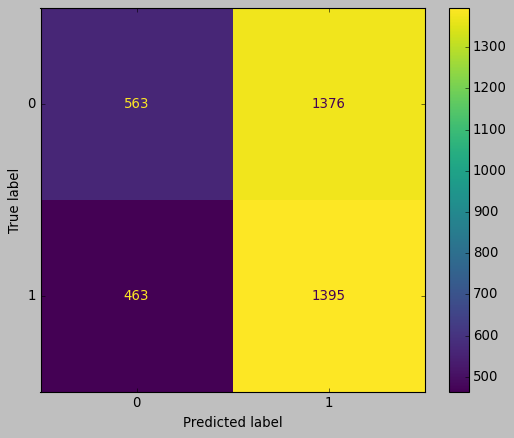

In [58]:
best_models_candle_3 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 3
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(train_X, train_y, batch_size=32, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat_test_3 = model.predict(test_X)
yhat_test_3 = yhat_test_3.reshape(yhat_test_3.shape[0])

for i in range(len(yhat_test_3)):
    if (yhat_test_3[i]>0.5):
        yhat_test_3[i] = 1
    else:
        yhat_test_3[i] = 0


metrics(test_y, yhat_test_3)

In [59]:
Evaluate_candles(0, test_y, yhat_test_3)

5 свечей

          close   SMA_200   EMA_200    SMA_50    EMA_50       RSI  \
0      0.280762  0.443070  0.386336  0.263786  0.288737  0.098102   
1      0.282055  0.441709  0.385280  0.263202  0.288585  0.212602   
2      0.278275  0.440296  0.384193  0.263034  0.288291  0.226520   
3      0.277795  0.438898  0.383115  0.262532  0.287989  0.348759   
4      0.269275  0.437294  0.381951  0.261502  0.287363 -0.109411   
...         ...       ...       ...       ...       ...       ...   
12155  1.171011  1.245529  1.284144  1.172910  1.177415  0.060722   
12156  1.169967  1.243389  1.283286  1.173138  1.177359 -0.612459   
12157  1.167879  1.241276  1.282415  1.173349  1.177223 -1.045175   
12158  1.165862  1.239252  1.281533  1.173476  1.177013 -1.322437   
12159  1.163521  1.237350  1.280635  1.173574  1.176720 -1.272687   

       width_open_high  width_open_low      macd  signal_line  histogram  \
0            -0.464720       -0.357964  0.119379     0.050484   0.243036   
1            -0.464

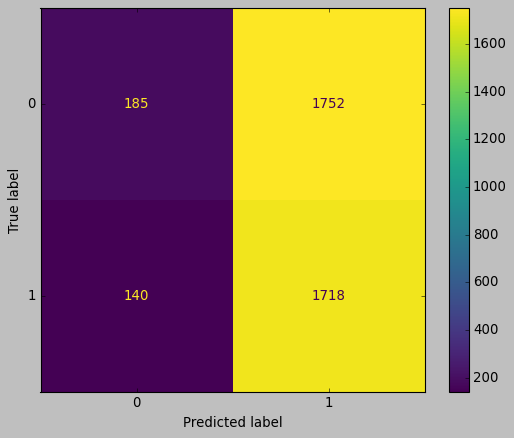

In [60]:
best_models_candle_5 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


print(train_X)
n_steps = 5
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(train_X, train_y, batch_size=32, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat_test_5 = model.predict(test_X)
yhat_test_5 = yhat_test_5.reshape(yhat_test_5.shape[0])

for i in range(len(yhat_test_5)):
    if (yhat_test_5[i]>0.5):
        yhat_test_5[i] = 1
    else:
        yhat_test_5[i] = 0


metrics(test_y, yhat_test_5)

In [61]:
Evaluate_candles(1, test_y, yhat_test_5)

10 свечей

Epoch 1/20
380/380 [==============================] - 12s 22ms/step - loss: 0.6945 - binary_accuracy: 0.5106 - val_loss: 0.6971 - val_binary_accuracy: 0.4980
Epoch 2/20
380/380 [==============================] - 7s 19ms/step - loss: 0.6940 - binary_accuracy: 0.5097 - val_loss: 0.6941 - val_binary_accuracy: 0.5178
Epoch 3/20
380/380 [==============================] - 7s 19ms/step - loss: 0.6924 - binary_accuracy: 0.5252 - val_loss: 0.6955 - val_binary_accuracy: 0.5132
Epoch 4/20
380/380 [==============================] - 7s 19ms/step - loss: 0.6921 - binary_accuracy: 0.5221 - val_loss: 0.6958 - val_binary_accuracy: 0.5172
Epoch 5/20
119/119 [==============================] - 1s 8ms/step
balanced_accuracy: 0.5020462437150092
precision: 0.4908062234794908
recall: 0.9348060344827587
f1-score: 0.6436653682062697


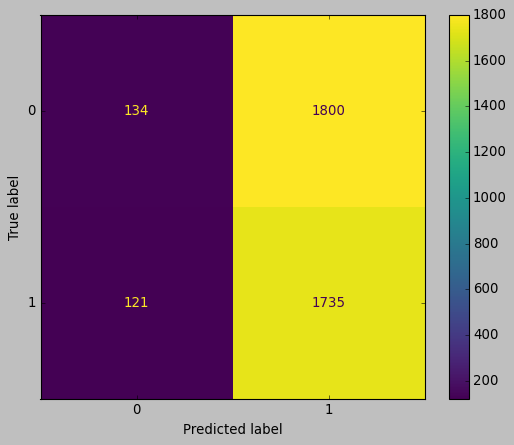

In [62]:
best_models_candle_10 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 10
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(train_X, train_y, batch_size=32, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat_test_10 = model.predict(test_X)
yhat_test_10 = yhat_test_10.reshape(yhat_test_10.shape[0])

for i in range(len(yhat_test_10)):
    if (yhat_test_10[i]>0.5):
        yhat_test_10[i] = 1
    else:
        yhat_test_10[i] = 0


metrics(test_y, yhat_test_10)

In [63]:
Evaluate_candles(2, test_y, yhat_test_10)

20 свечей

Epoch 1/20
380/380 [==============================] - 16s 33ms/step - loss: 0.6985 - binary_accuracy: 0.5100 - val_loss: 0.6951 - val_binary_accuracy: 0.5106
Epoch 2/20
380/380 [==============================] - 12s 31ms/step - loss: 0.6940 - binary_accuracy: 0.5120 - val_loss: 0.7014 - val_binary_accuracy: 0.5053
Epoch 3/20
380/380 [==============================] - 12s 32ms/step - loss: 0.6982 - binary_accuracy: 0.5245 - val_loss: 0.6955 - val_binary_accuracy: 0.5212
Epoch 4/20
380/380 [==============================] - 12s 31ms/step - loss: 0.6934 - binary_accuracy: 0.5250 - val_loss: 0.6996 - val_binary_accuracy: 0.5159
Epoch 5/20
380/380 [==============================] - 13s 35ms/step - loss: 0.6936 - binary_accuracy: 0.5279 - val_loss: 0.6967 - val_binary_accuracy: 0.5060
Epoch 6/20
119/119 [==============================] - 4s 21ms/step
balanced_accuracy: 0.5298515614059656
precision: 0.5323686214775324
recall: 0.37783783783783786
f1-score: 0.44198545684476764


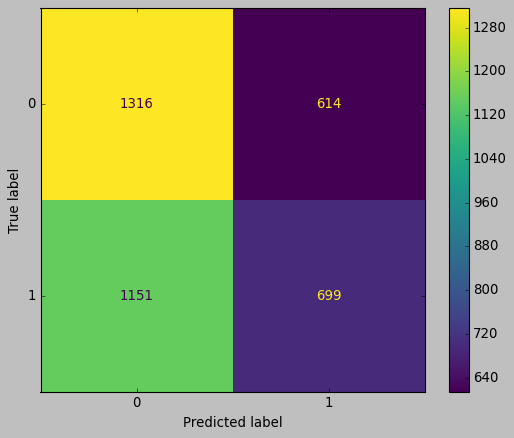

In [64]:
best_models_candle_20 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 20
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'relu',return_sequences=True))
model.add(LSTM(56, activation = 'relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["binary_accuracy"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
model.fit(train_X, train_y, batch_size=32, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])
# plot history

yhat_test_20 = model.predict(test_X)
yhat_test_20 = yhat_test_20.reshape(yhat_test_20.shape[0])

for i in range(len(yhat_test_20)):
    if (yhat_test_20[i]>0.5):
        yhat_test_20[i] = 1
    else:
        yhat_test_20[i] = 0


metrics(test_y, yhat_test_20)

In [65]:
Evaluate_candles(3, test_y, yhat_test_20)

In [66]:
Table_of_Comapring_candles = For_Comparing_candles.copy()
Table_of_Comapring_candles.index = ['3','5','10','20']
Table_of_Comapring_candles

,precision,recall,accuracy,f1
3,0.503428,0.750807,0.520582,0.602722
5,0.495101,0.924650,0.510079,0.644895
10,0.490806,0.934806,0.502046,0.643665
20,0.532369,0.377838,0.529852,0.441985


20

# NN selection

Выбор наилучшего архитектуры

In [67]:
For_Comparing_NN = pd.DataFrame(np.zeros([5,4]), columns=['precision','recall','accuracy','f1'])

def Evaluate_NN(n, real,forecast):
    For_Comparing_NN.loc[n,'precision']  = round(precision_score(real, forecast),20)
    For_Comparing_NN.loc[n,'recall']   = round(recall_score(real, forecast),20)
    For_Comparing_NN.loc[n,'accuracy'] = round(balanced_accuracy_score(real, forecast), 20)
    For_Comparing_NN.loc[n,'f1']  = round(f1_score(real, forecast),20)

In [68]:
n_steps = 3

LSTM

Trial 10 Complete [00h 01m 34s]
val_binary_accuracy: 0.5103721022605896

Best val_binary_accuracy So Far: 0.5195916891098022
Total elapsed time: 00h 24m 52s
INFO:tensorflow:Oracle triggered exit
119/119 [==============================] - 3s 19ms/step
balanced_accuracy: 0.5131111383749016
precision: 0.4968344889960808
recall: 0.8869752421959096
f1-score: 0.6369082125603865


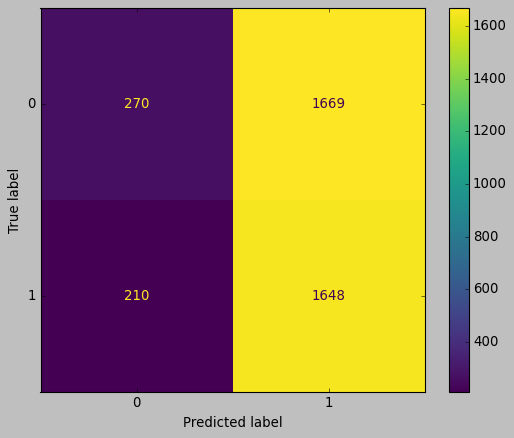

In [70]:
def build_model_LSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(LSTM(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True))
    
    model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_LSTM,
                      objective="val_binary_accuracy",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=10,
                      #seed=123,
                      project_name="BTC1HLSTM-binary",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=32, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat_test_LSTM = best_model_.predict(test_X)
yhat_test_LSTM = yhat_test_LSTM.reshape(yhat_test_LSTM.shape[0])

for i in range(len(yhat_test_LSTM)):
    if (yhat_test_LSTM[i]>0.5):
        yhat_test_LSTM[i] = 1
    else:
        yhat_test_LSTM[i] = 0


metrics(test_y, yhat_test_LSTM)

In [71]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 344)            496736    
                                                                 
 lstm_1 (LSTM)               (None, 3, 208)            460096    
                                                                 
 lstm_2 (LSTM)               (None, 3, 208)            346944    
                                                                 
 lstm_3 (LSTM)               (None, 88)                104544    
                                                                 
 dense (Dense)               (None, 1)                 89        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 1,408,409
Trainable params: 1,408,409
Non-

In [72]:
Evaluate_NN(0, test_y, yhat_test_LSTM)

GRU

Trial 10 Complete [00h 03m 08s]
val_binary_accuracy: 0.5156404376029968

Best val_binary_accuracy So Far: 0.5189331769943237
Total elapsed time: 00h 22m 23s
INFO:tensorflow:Oracle triggered exit
119/119 [==============================] - 2s 13ms/step
balanced_accuracy: 0.5320836370439413
precision: 0.5122134535888764
recall: 0.7335844994617868
f1-score: 0.6032308032750608


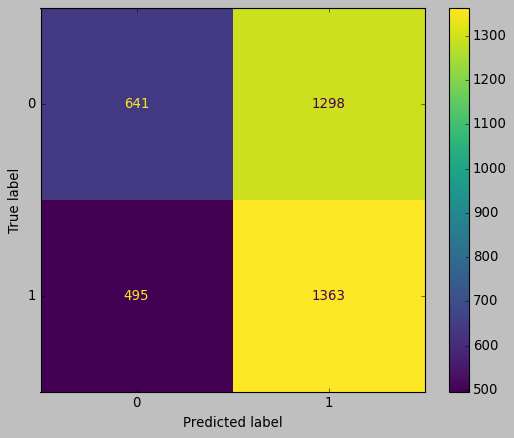

In [73]:
def build_model_GRU(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(GRU(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(GRU(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True))
    
    model.add(GRU(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_GRU,
                      objective="val_binary_accuracy",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=10,
                      #seed=123,
                      project_name="BTC1HGRU-binary",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=32, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat_test_GRU = best_model_.predict(test_X)
yhat_test_GRU = yhat_test_GRU.reshape(yhat_test_GRU.shape[0])

for i in range(len(yhat_test_GRU)):
    if (yhat_test_GRU[i]>0.5):
        yhat_test_GRU[i] = 1
    else:
        yhat_test_GRU[i] = 0


metrics(test_y, yhat_test_GRU)

In [74]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 320)            324480    
                                                                 
 gru_1 (GRU)                 (None, 3, 208)            330720    
                                                                 
 gru_2 (GRU)                 (None, 3, 208)            260832    
                                                                 
 gru_3 (GRU)                 (None, 88)                78672     
                                                                 
 dense (Dense)               (None, 1)                 89        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 994,793
Trainable params: 994,793
Non-trai

In [75]:
Evaluate_NN(1, test_y, yhat_test_GRU)

BiLSTM

Trial 10 Complete [00h 19m 27s]
val_binary_accuracy: 0.5083964467048645

Best val_binary_accuracy So Far: 0.5212380886077881
Total elapsed time: 01h 55m 56s
INFO:tensorflow:Oracle triggered exit
119/119 [==============================] - 7s 38ms/step
balanced_accuracy: 0.5287186252831934
precision: 0.5057091346153846
recall: 0.9058127018299247
f1-score: 0.6490551484766679


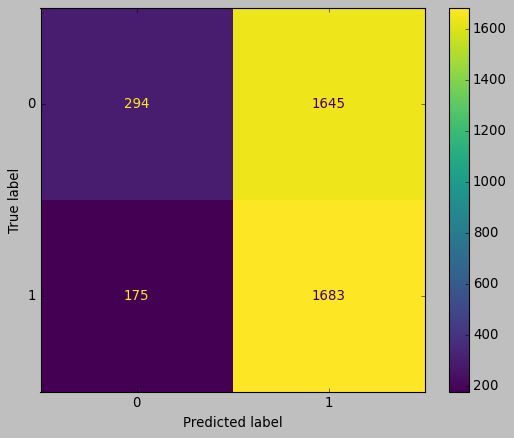

In [76]:
def build_model_BiLSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(Bidirectional(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True)))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(Bidirectional(LSTM(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True)))
    
    model.add(Bidirectional(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice)))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_BiLSTM,
                      objective="val_binary_accuracy",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=10,
                      #seed=123,
                      project_name="BTC1HBiLSTM-binary",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=32, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat_test_BiLSTM = best_model_.predict(test_X)
yhat_test_BiLSTM = yhat_test_BiLSTM.reshape(yhat_test_BiLSTM.shape[0])

for i in range(len(yhat_test_BiLSTM)):
    if (yhat_test_BiLSTM[i]>0.5):
        yhat_test_BiLSTM[i] = 1
    else:
        yhat_test_BiLSTM[i] = 0


metrics(test_y, yhat_test_BiLSTM)

In [77]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 3, 928)           1785472   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 368)           1638336   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 176)              321728    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 177       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                        

In [78]:
Evaluate_NN(2, test_y, yhat_test_BiLSTM)

BiGRU

Trial 10 Complete [00h 04m 16s]
val_binary_accuracy: 0.5166282653808594

Best val_binary_accuracy So Far: 0.5235429406166077
Total elapsed time: 00h 42m 51s
INFO:tensorflow:Oracle triggered exit
119/119 [==============================] - 5s 25ms/step
balanced_accuracy: 0.5178792792662759
precision: 0.5016310257339616
recall: 0.7448869752421959
f1-score: 0.5995235001082955


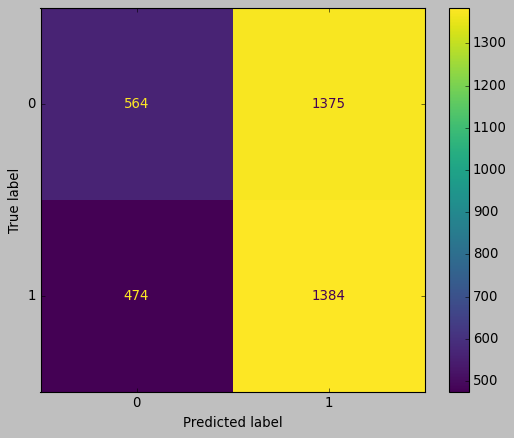

In [87]:
def build_model_BiGRU(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(Bidirectional(GRU(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True)))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(Bidirectional(GRU(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True)))
    
    model.add(Bidirectional(GRU(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice)))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_BiGRU,
                      objective="val_binary_accuracy",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=10,
                      #seed=123,
                      project_name="BTC1HBiGRU-binary",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=72, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat_test_BiGRU = best_model_.predict(test_X)
yhat_test_BiGRU = yhat_test_BiGRU.reshape(yhat_test_BiGRU.shape[0])

for i in range(len(yhat_test_BiGRU)):
    if (yhat_test_BiGRU[i]>0.5):
        yhat_test_BiGRU[i] = 1
    else:
        yhat_test_BiGRU[i] = 0


metrics(test_y, yhat_test_BiGRU)

In [88]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 3, 704)           781440    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 384)           1034496   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 176)              250272    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 177       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                        

In [89]:
Evaluate_NN(3, test_y, yhat_test_BiGRU)

Conv-LSTM

Trial 3 Complete [00h 00m 23s]
val_binary_accuracy: 0.5133355259895325

Best val_binary_accuracy So Far: 0.5159696936607361
Total elapsed time: 00h 01m 14s
INFO:tensorflow:Oracle triggered exit
119/119 [==============================] - 1s 2ms/step
balanced_accuracy: 0.524027233195898
precision: 0.5044865403788634
recall: 0.8170075349838536
f1-score: 0.6237928908978838


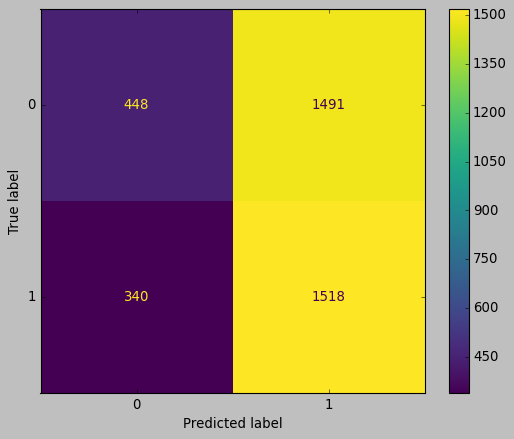

In [82]:
def build_model_ConvLSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(ConvLSTM2D(input_shape=(1, 1, train_X.shape[3], train_X.shape[4]),
                            activation=activation_choice, filters=32, padding='same', kernel_size=(1,5)))
    
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(loss='binary_crossentropy', metrics=["binary_accuracy"])

    return model


scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)


train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)

train_X = train_X.reshape((train_X.shape[0], 1, 1, train_X.shape[1],train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], 1, 1, test_X.shape[1],test_X.shape[2]))
val_X = val_X.reshape((val_X.shape[0], 1, 1, val_X.shape[1],val_X.shape[2]))

print(train_X.shape)

train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]

from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_ConvLSTM,
                      objective="val_binary_accuracy",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=3,
                      #seed=123,
                      project_name="BTC1HCONVLSTM-binary",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=32, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]

yhat_test_CONVLSTM = best_model_.predict(test_X)
yhat_test_CONVLSTM = yhat_test_CONVLSTM.reshape(yhat_test_CONVLSTM.shape[0])

for i in range(len(yhat_test_CONVLSTM)):
    if (yhat_test_CONVLSTM[i]>0.5):
        yhat_test_CONVLSTM[i] = 1
    else:
        yhat_test_CONVLSTM[i] = 0


metrics(test_y, yhat_test_CONVLSTM)

In [83]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 3, 32)          30848     
                                                                 
 flatten (Flatten)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 30,945
Trainable params: 30,945
Non-trainable params: 0
_________________________________________________________________


In [84]:
Evaluate_NN(4, test_y, yhat_test_CONVLSTM)

In [90]:
Table_of_Comapring_NN = For_Comparing_NN.copy()
Table_of_Comapring_NN.index = ['LSTM','GRU','BiLSTM','BiGRU','CONV-LSTM']
Table_of_Comapring_NN

,precision,recall,accuracy,f1
LSTM,0.496834,0.886975,0.513111,0.636908
GRU,0.512213,0.733584,0.532084,0.603231
BiLSTM,0.505709,0.905813,0.528719,0.649055
BiGRU,0.501631,0.744887,0.517879,0.599524
CONV-LSTM,0.504487,0.817008,0.524027,0.623793


Лучше всего себя показали BiLSTM, BiGRU, CONV-LSTM сеть

In [73]:
print(scaler.mean, scaler.scale)

AttributeError: 'StandardScaler' object has no attribute 'mean_'